# CASAS Aruba

WSU CASAS smart home project:  
    D. Cook. Learning setting-generalized activity models for smart spaces. IEEE Intelligent Systems, 2011.


### Description
This dataset contains sensor data that was collected in the home of
a volunteer adult.  The resident in the home was a woman.  The woman's
children and grandchildren visited on a regular basis.

#### Data cleaning
The data was in a very desolate state. Therefore this script fixes typos spaces and mislabeling of devices. The cleaned data is used for analysis.

In [13]:
import sys
sys.path.append("../..")
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

In [15]:
from pyadlml.dataset import set_data_home, fetch_casas_aruba
set_data_home('/home/chris/code/adlml/data_home')

data = fetch_casas_aruba(keep_original=True, cache=True)

In [16]:
data.df_activities.head()

,start_time,end_time,activity
0,2010-11-04 00:03:50.209589,2010-11-04 05:40:43.642664,Sleeping
1,2010-11-04 05:40:51.303739,2010-11-04 05:43:30.279021,Bed_to_Toilet
2,2010-11-04 05:43:45.732400,2010-11-04 08:01:12.282970,Sleeping
3,2010-11-04 08:11:09.966157,2010-11-04 08:27:02.801314,Meal_Preparation
4,2010-11-04 08:33:52.929406,2010-11-04 08:35:45.822482,Meal_Preparation


In [17]:
data.df_devices.head()

,time,device,val
0,2010-11-04 00:03:50.209589,M003,True
1,2010-11-04 00:03:57.399391,M003,False
2,2010-11-04 02:32:33.351906,M003,True
3,2010-11-04 02:32:38.895958,M003,False
4,2010-11-04 03:42:21.823650,M003,True


## Activities: Person 1


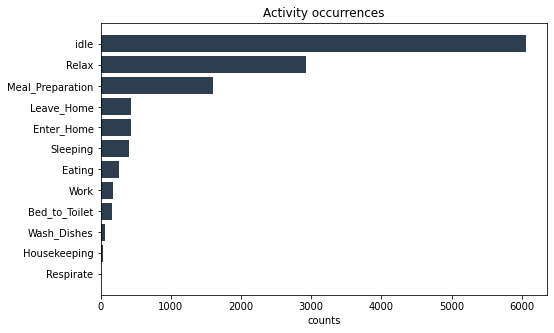

In [18]:
from pyadlml.dataset.plot.activities import hist_counts

idle = True
hist_counts(data.df_activities, idle=idle);

The most performed activity is *use toilet* and *go to bed*. There is an exponential decay between the amount of the most and least performed activity.

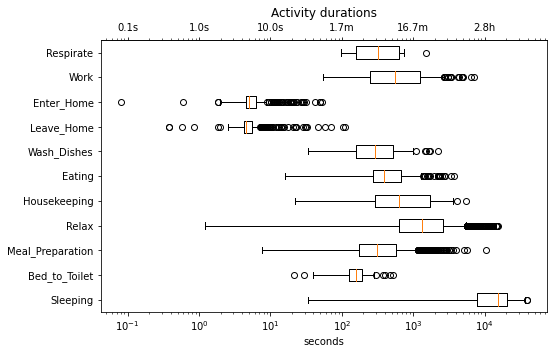

In [7]:
from pyadlml.dataset.plot.activities import boxplot_duration

idle = False
boxplot_duration(data.df_activities, idle=idle);

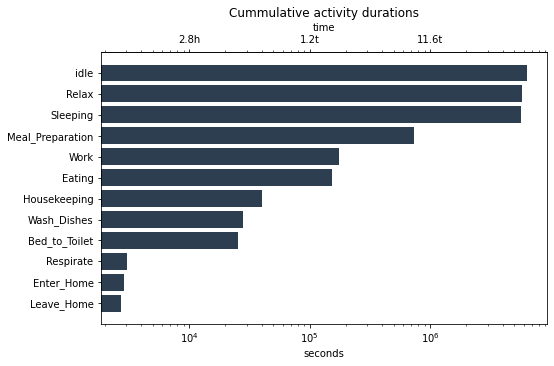

In [8]:
from pyadlml.dataset.plot.activities import hist_cum_duration

idle = True
y_scale = 'log'
hist_cum_duration(data.df_activities, y_scale=y_scale, idle=idle);

#### Transition Heatmap

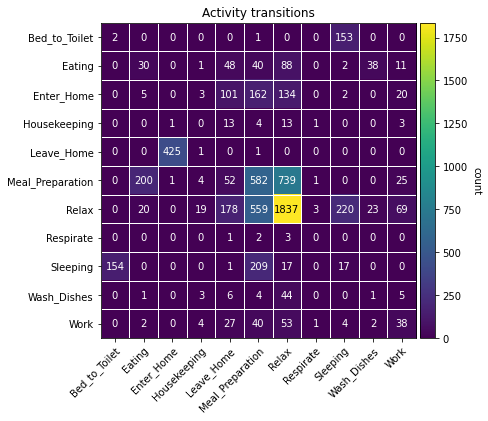

In [9]:
from pyadlml.dataset.plot.activities import heatmap_transitions

idle = False
z_scale = None #'log'
heatmap_transitions(data.df_activities, z_scale=z_scale, idle=idle);

## Devices

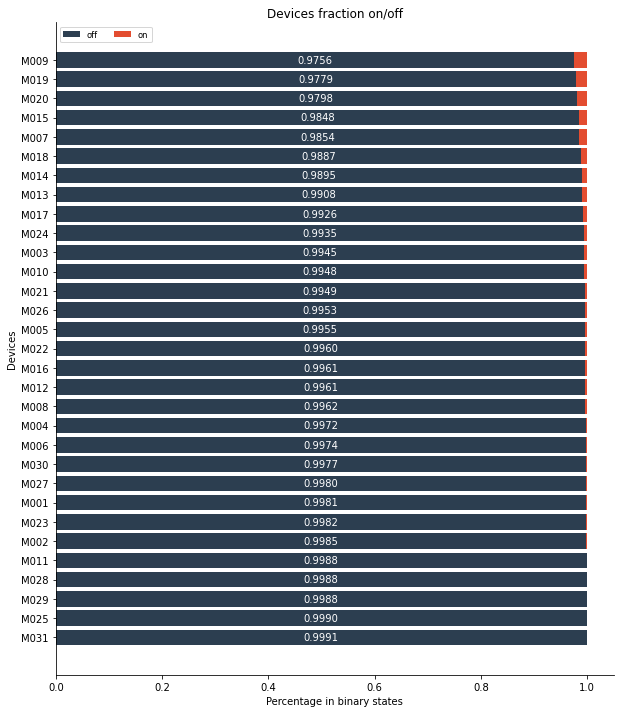

In [21]:
from pyadlml.dataset.plot.devices import hist_on_off
hist_on_off(data.df_devices);

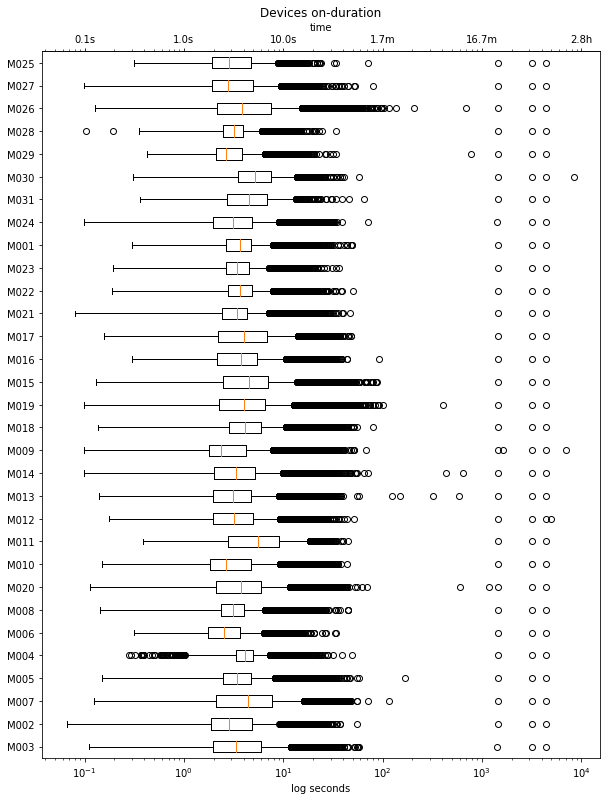

In [20]:
from pyadlml.dataset.plot.devices import boxplot_on_duration
boxplot_on_duration(data.df_devices);#, figsize=(11,11));

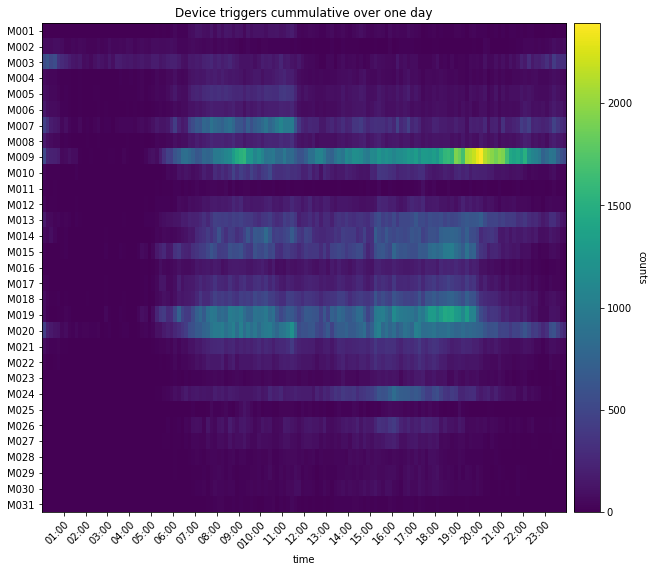

In [22]:
from pyadlml.dataset.plot.devices import heatmap_trigger_one_day
heatmap_trigger_one_day(data.df_devices, t_res='10m');#, figsize=(11,11));

In [ ]:
from pyadlml.dataset.plot.devices import heatmap_trigger_time

t_window = '5s'
z_scale = 'log'

heatmap_trigger_time(data.df_devices, t_window=t_window, z_scale=z_scale, figsize=(8,8))

In [ ]:
from pyadlml.dataset.plot.devices import heatmap_cross_correlation
heatmap_cross_correlation(data.df_devices, numbers=False, grid=False)

In [ ]:
from pyadlml.dataset.plot.devices import hist_trigger_time_diff
hist_trigger_time_diff(data.df_devices);

We can see that about $33\%$ of the triggers preceed each other in a timeslice lower than $1$ second and about $80\%$ of the triggers in a timeslice lower than $1$ minute. In the paper (cite kasteren) a timeslice of $60$ seconds was used.

In [ ]:
from pyadlml.dataset.plot.devices import hist_counts
hist_counts(data.df_devices, y_scale='log');

# Activites ~ Devices


### Triggers
Lets look at the connection between the activities and the device activations.

In [ ]:
from pyadlml.dataset.plot import heatmap_contingency_triggers

idle = True
z_scale = 'log'

heatmap_contingency_triggers(data.df_dev_rep3, data.df_activities, idle=idle, z_scale=z_scale)

We can see that there are sensors that heavily trigger for certain activities e.g hall-bathroom door and use toilet

In [ ]:
from pyadlml.dataset.plot import heatmap_contingency_triggers_01

idle = True
z_scale = 'log'

heatmap_contingency_triggers_01(data.df_dev_rep3, data.df_activities, 
                                idle=idle, z_scale=z_scale);

Sadly the different states of a device don't convey much information. It would have been nice if an activity is only involved with a single device transition.

## Duration

the overlap of the intervals is also interesting.

In [ ]:
from pyadlml.dataset.plot import heatmap_contingency_overlaps

z_scale='log'
idle=True

heatmap_contingency_overlaps(data.df_devices, data.df_activities, z_scale=z_scale, idle=idle)

# Representations

There are different ways to represent our data. One way is to discretize the data into intervals.

- RAW representation _____|^^^^^^|______  
    is 1 whenever the sensor is 'on' and 0 otherwise 

- Changepoint representation ______|________|______  
    sensor gives a 1 to timeslices where the sensor reading changes

- LastFired representation ______|^^^^^^^^^  
    last sensor that changed state gives cont. 1

- Lagged representation
    the 

## RAW - representation

In [ ]:
from pyadlml.preprocessing import RawEncoder

enc_raw = RawEncoder()
raw = enc_raw.fit_transform(data.df_devices)

In [ ]:
from pyadlml.preprocessing import LabelEncoder

enc_lbl = LabelEncoder(raw)
lbls = enc_lbl.fit_transform(data.df_activities)

In [ ]:
import numpy as np

def check_raw_undiscretized(raw):
    # should not contain any  nan values
    assert not raw.isnull().values.any()
    
    # rows can only differ in one number
    for i in range(1, len(raw)):
        assert 1 == np.abs(np.sum(raw.iloc[i-1].values - raw.iloc[i].values))
    
check_raw_undiscretized(raw)

In [ ]:
def check_raw(raw):
    # should not contain any  nan values
    assert not raw.isnull().values.any()
    
check_raw(raw)

In [ ]:
from pyadlml.dataset.plot.raw import hist_activities

hist_activities(enc_lbl.inverse_transform(lbls), 
                scale='log')#, figsize=(10,10))

In [ ]:
from pyadlml.dataset.plot.raw import heatmap_contingency_01

z_scale = 'log'
rep = 'raw'

heatmap_contingency_01(raw, enc_lbl.inverse_transform(lbls), rep=rep, z_scale=z_scale);

In [ ]:
from pyadlml.dataset.plot.raw import heatmap_cross_correlation

heatmap_cross_correlation(raw);

In [ ]:
# TODO sth. is wrong here
#from pyadlml.dataset.plot.raw import corr_devices_01
#corr_devices_01(raw)

## Changepoint - representation
Raw: _____|^^^^^^|______  

CP :  ______|________|______  

sensor gives a 1 to timeslices where the sensor reading changes

In [ ]:
from pyadlml.preprocessing import ChangepointEncoder

idle = True
t_res = '60s'

cp_enc = ChangepointEncoder(t_res=t_res)
cp = cp_enc.fit_transform(data.df_devices)

In [ ]:
from pyadlml.preprocessing import LabelEncoder

enc_lbl = LabelEncoder(cp, idle=idle)
lbls = enc_lbl.fit_transform(data.df_activities)

In [ ]:
def check_changepoint(cp):
    # should not contain any  nan values
    assert not cp.isnull().values.any()

check_changepoint(cp)

In [ ]:
from pyadlml.dataset.plot.raw import heatmap_contingency_01

z_scale = 'log'
rep = 'Changepoint'

heatmap_contingency_01(cp, enc_lbl.inverse_transform(lbls), rep=rep, z_scale=z_scale);

In [ ]:
from pyadlml.dataset.plot.raw import heatmap_cross_correlation

heatmap_cross_correlation(cp);

## LastFired - representation
______|^^^^^^^^^  

last sensor that changed state gives cont. 1

In [ ]:
from pyadlml.preprocessing import LastFiredEncoder

t_res = '60s'
idle=True

lf_enc = LastFiredEncoder(t_res=t_res)
lf = lf_enc.fit_transform(data.df_devices)

In [ ]:
from pyadlml.preprocessing import LabelEncoder

enc_lbl = LabelEncoder(lf, idle=idle)
lbls = enc_lbl.fit_transform(data.df_activities)

In [ ]:
def check_lastfired(lf):
    # should not contain any  nan values
    assert not lf.isnull().values.any()
    
    # each row has to have exactly one device being on
    for row in lf.iterrows():
        assert 1 == row[1].values.sum()

check_lastfired(lf)

In [ ]:
from pyadlml.dataset.plot.raw import heatmap_contingency_01

z_scale = 'log'
rep = 'LastFired'

heatmap_contingency_01(lf, enc_lbl.inverse_transform(lbls), rep=rep, z_scale=z_scale);

In [ ]:
from pyadlml.dataset.plot.raw import heatmap_cross_correlation

heatmap_cross_correlation(lf);

## Image - representation

a lot of timeseries can be represented as images. There are good algorithms for images available. There are Recurrence Plots (RP), Gramian Angular Field (GAF) (bad for binary data), Markov Transition Field (MTF): https://doi.org/10.3390/electronics9010068.


Gramian Angular field: 
    https://medium.com/analytics-vidhya/encoding-time-series-as-images-b043becbdbf3
    
    https://pyts.readthedocs.io/en/stable/auto_examples/image/plot_mtf.html#sphx-glr-auto-examples-image-plot-mtf-py

### Lagged RAW

The lagged raw representation generates a 3D tensor from the raw input. A state at time $t$ is $1D$ vector. The window size determines how big the $2D$ picture is. Stack the windows in the third dimension.

Also see last part of
https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe

In [ ]:
from pyadlml.preprocessing import LaggedRawEncoder, LaggedLabelEncoder

window_size = 20
t_res = '2min'
sample_strat = 'int_coverage'
idle = True

enc_lgd_raw = LaggedRawEncoder(window_size, 
                               t_res=t_res, 
                               sample_strat=sample_strat)

images = enc_lgd_raw.fit_transform(data.df_devices)

In [ ]:
images.shape

In [ ]:
enc_lgd_lbl = LaggedLabelEncoder(data.df_devices,
                                        window_size, 
                                        t_res=t_res,
                                        idle=idle)

labels = enc_lgd_lbl.fit_transform(data.df_activities)
labels.shape

In [ ]:
from pyadlml.dataset.plot.image import mean_image

mean_image(images, data.devices)

In [ ]:
from pyadlml.dataset.plot.image import mean_image_per_activity

X = images
y = enc_lgd_lbl.inverse_transform(labels)

mean_image_per_activity(X, y, data.devices)

# Lagged Changepoint representation

In [ ]:
from pyadlml.preprocessing import LaggedChangepointEncoder
window_size = 20
t_res = '2min'
sample_strat = 'int_coverage'
idle = True


enc_lgd_cp = LaggedChangepointEncoder(window_size, t_res=t_res)
images = enc_lgd_cp.fit_transform(data.df_devices)
images.shape

In [ ]:
from pyadlml.dataset.plot.image import mean_image

mean_image(images, data.devices)

In [ ]:
enc_lgd_lbl = LaggedLabelEncoder(data.df_devices,
                                        window_size, 
                                        t_res=t_res,
                                        idle=idle)

labels = enc_lgd_lbl.fit_transform(data.df_activities)
labels.shape

In [ ]:
from pyadlml.dataset.plot.image import mean_image_per_activity

X = images
y = enc_lgd_lbl.inverse_transform(labels)

mean_image_per_activity(X, y, data.devices)

## Lagged Last Fired Encoder

In [ ]:
from pyadlml.preprocessing import LaggedLastFiredEncoder
window_size = 20
t_res = '2min'
sample_strat = 'int_coverage'
idle=True


enc_lgd_lf = LaggedLastFiredEncoder(window_size, t_res=t_res)
images = enc_lgd_lf.fit_transform(data.df_devices)
images.shape

In [ ]:
from pyadlml.dataset.plot.image import mean_image

mean_image(images, data.devices)

In [ ]:
enc_lgd_lbl = LaggedLabelEncoder(data.df_devices,
                                        window_size, 
                                        t_res=t_res,
                                        idle=idle)

labels = enc_lgd_lbl.fit_transform(data.df_activities)
labels.shape

In [ ]:
from pyadlml.dataset.plot.image import mean_image_per_activity

X = images
y = enc_lgd_lbl.inverse_transform(labels)

mean_image_per_activity(X, y, data.devices)